# ml lab8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. load dataset

In [2]:
!chmod +x ./download_data.sh 
!./download_data.sh

data/sign-language-mnist already exist


### 1. train / test split

In [20]:
DATASET_DIR = './data/sign-language-mnist'

train_df = pd.read_csv(f'{DATASET_DIR}/sign_mnist_train.csv')
test_df = pd.read_csv(f'{DATASET_DIR}/sign_mnist_test.csv')

In [21]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [59]:
labels_count = len(set(train_df.label))
labels_count

24

In [23]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)
train_df.shape, val_df.shape, test_df.shape

((20591, 785), (6864, 785), (7172, 785))

In [147]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

image_width = 28
batch_size = 64

def cook_data(df, shuffle, generator=ImageDataGenerator(rescale=1./255), expand=False):
    new_df = df.reset_index(drop=True)
    labels = new_df.label.values
    images = new_df.drop(columns='label').values.reshape(-1, image_width, image_width, 1)
    
    if expand:
        images = np.concatenate([images] * 3, axis=-1)
        pad = (2, 2)
        images = np.pad(images, ((0, 0), pad, pad, (0, 0)), constant_values=(0, 0))
    print(images.shape)
    
    return generator.flow(
        images,
        to_categorical(labels),
        batch_size=batch_size,
        shuffle=shuffle,
    )

In [148]:
train = cook_data(train_df, True)
val = cook_data(val_df, False)
test = cook_data(test_df, False)

(20591, 28, 28, 1)
(6864, 28, 28, 1)
(7172, 28, 28, 1)


### 2. build network

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Dropout, Flatten

def build_model():
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=(image_width, image_width, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(labels_count + 1, activation='softmax'))
    
    return model

In [90]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 12, 12, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)         

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train,
    validation_data=val,
    epochs=10,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 322 steps, validate for 108 steps
Epoch 1/10
322/322 [==============================] - 6s 20ms/step - loss: 1.2148 - accuracy: 0.6414 - val_loss: 2.2820 - val_accuracy: 0.2599
Epoch 2/10
322/322 [==============================] - 6s 18ms/step - loss: 0.2128 - accuracy: 0.9289 - val_loss: 0.0817 - val_accuracy: 0.9774
Epoch 3/10
322/322 [==============================] - 6s 18ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.0053 - val_accuracy: 0.9996
Epoch 4/10
322/322 [==============================] - 6s 18ms/step - loss: 0.0460 - accuracy: 0.9865 - val_loss: 0.0100 - val_accuracy: 0.9990
Epoch 5/10
322/322 [==============================] - 6s 18ms/step - loss: 0.0309 - accuracy: 0.9910 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 6/10
322/322 [==============================] - 6s 20ms/step - loss: 0.0214 - accuracy: 0.9939 - val_loss: 4.4416e-04 - val_accuracy: 1.0000
Epoch 7/10
322/322 [========================

In [98]:
def evaluate(model, history):
    results = model.evaluate(test)
    print(f'Train accuracy: {history.history["accuracy"][-1]*100:.2f}%')
    print(f'Test accuracy: {results[-1]*100:.2f}%')

In [99]:
evaluate(model, history)

  ...
    to  
  ['...']
113/113 [==============================] - 0s 4ms/step - loss: 0.1948 - accuracy: 0.9426
Train accuracy: 99.53%
Test accuracy: 94.26%


In [100]:
def plot(_history):    
    plt.figure(figsize=(8, 6))
    plt.plot(_history.history['accuracy'], 'r')
    plt.plot(_history.history['val_accuracy'], 'b')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

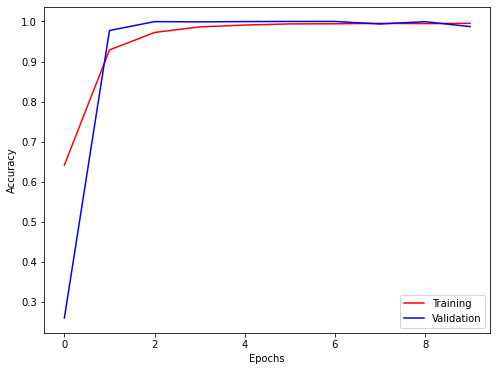

In [106]:
plot(history)

### 2. data augmentation

In [150]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)


train = cook_data(train_df, True, train_generator)
val = cook_data(val_df, False)
test = cook_data(test_df, True)

(20591, 28, 28, 1)
(6864, 28, 28, 1)
(7172, 28, 28, 1)


In [151]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [152]:
history = model.fit(
    train, 
    epochs=10,
    validation_data=test,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 322 steps, validate for 113 steps
Epoch 1/10
322/322 [==============================] - 7s 23ms/step - loss: 2.3919 - accuracy: 0.3370 - val_loss: 4.3232 - val_accuracy: 0.1341
Epoch 2/10
322/322 [==============================] - 7s 21ms/step - loss: 1.1566 - accuracy: 0.6132 - val_loss: 0.5382 - val_accuracy: 0.8424
Epoch 3/10
322/322 [==============================] - 7s 21ms/step - loss: 0.7449 - accuracy: 0.7421 - val_loss: 0.5061 - val_accuracy: 0.8331
Epoch 4/10
322/322 [==============================] - 7s 20ms/step - loss: 0.5581 - accuracy: 0.8062 - val_loss: 0.2685 - val_accuracy: 0.9179
Epoch 5/10
322/322 [==============================] - 8s 23ms/step - loss: 0.4268 - accuracy: 0.8529 - val_loss: 0.2150 - val_accuracy: 0.9232
Epoch 6/10
322/322 [==============================] - 8s 24ms/step - loss: 0.3549 - accuracy: 0.8792 - val_loss: 0.1810 - val_accuracy: 0.9442
Epoch 7/10
322/322 [============================

In [153]:
evaluate(model, history)

  ...
    to  
  ['...']
113/113 [==============================] - 0s 4ms/step - loss: 0.1069 - accuracy: 0.9787
Train accuracy: 92.59%
Test accuracy: 97.87%


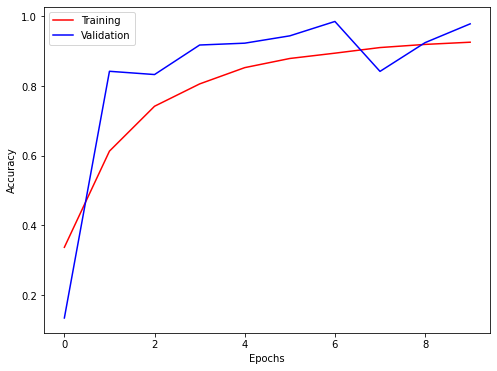

In [154]:
plot(history)

> augmentation prevents overfitting

### 4. Try VGG16

> The default input size for this model is `299x299x3`.

> width and height should be no smaller than `32`

In [155]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)


train = cook_data(train_df, True, train_generator, expand=True)
val = cook_data(val_df, False, ImageDataGenerator(rescale=1./255), expand=True)
test = cook_data(test_df, True, ImageDataGenerator(rescale=1./255), expand=True)

(20591, 32, 32, 3)
(6864, 32, 32, 3)
(7172, 32, 32, 3)


In [157]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

image_shape = (32, 32, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

for i, layer in enumerate(base_model.layers):
    layer.trainable = i > 20

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(labels_count + 1, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [159]:
history = model.fit(
    train, 
    epochs=20,
    validation_data=val,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 322 steps, validate for 108 steps
Epoch 1/20
322/322 [==============================] - 28s 88ms/step - loss: 0.8279 - accuracy: 0.7090 - val_loss: 0.7640 - val_accuracy: 0.7341
Epoch 2/20
322/322 [==============================] - 33s 101ms/step - loss: 0.8022 - accuracy: 0.7188 - val_loss: 0.7954 - val_accuracy: 0.7162
Epoch 3/20
322/322 [==============================] - 33s 101ms/step - loss: 0.7817 - accuracy: 0.7263 - val_loss: 0.8450 - val_accuracy: 0.6879
Epoch 4/20
322/322 [==============================] - 32s 101ms/step - loss: 0.7672 - accuracy: 0.7305 - val_loss: 0.7095 - val_accuracy: 0.7461
Epoch 5/20
322/322 [==============================] - 33s 102ms/step - loss: 0.7550 - accuracy: 0.7370 - val_loss: 0.7092 - val_accuracy: 0.7423
Epoch 6/20
322/322 [==============================] - 33s 102ms/step - loss: 0.7299 - accuracy: 0.7439 - val_loss: 0.7102 - val_accuracy: 0.7411
Epoch 7/20
322/322 [=================

In [160]:
evaluate(model, history)

  ...
    to  
  ['...']
113/113 [==============================] - 7s 58ms/step - loss: 0.8935 - accuracy: 0.6735
Train accuracy: 78.94%
Test accuracy: 67.35%


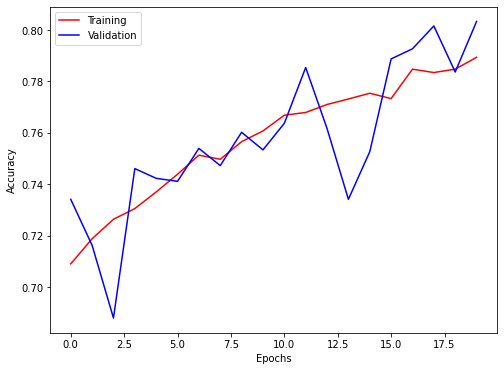

In [161]:
plot(history)